In [2]:
import sys
import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.initializers import RandomNormal
from functools import partial

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array,array_to_img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array,array_to_img
import keras
from tensorflow.keras.applications.vgg19 import VGG19

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
class PixelNormalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(PixelNormalization,self).__init__(**kwargs)
    def call(self,x):
        value = x**2
        mean = K.mean(value, axis = -1, keepdims=True)
        x = x/K.sqrt(mean + 1.0e-8)
        return x
class WeightedSum(tf.keras.layers.Add):
    # init with default value
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = K.variable(alpha, name='ws_alpha')

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'alpha' : 0.0
        })
        return config

    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        # ((1-a) * input1) + (a * input2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output
    
class MinibatchStdev(tf.keras.layers.Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = K.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = K.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = K.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = K.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = K.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = K.shape(inputs)
        output = K.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = K.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)
class RandomWeightedAverage(tf.keras.layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        alpha = tf.random.uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]
    
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'batch_size': self.batch_size,
            
        })
        return config
    
def gradient_penalty(y_true, y_pred, discriminator,gradient_penalty_weight):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
      

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(y_pred)
            # 1. Get the discriminator output for this interpolated image.
            pred = discriminator(y_pred, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [y_pred])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp*gradient_penalty_weight
    
from tensorflow.keras.applications.vgg19 import VGG19
class Cut_VGG19:
    """
    Class object that fetches keras' VGG19 model trained on the imagenet dataset
    and declares <layers_to_extract> as output layers. Used as feature extractor
    for the perceptual loss function.
    Args:
        layers_to_extract: list of layers to be declared as output layers.
        patch_size: integer, defines the size of the input (patch_size x patch_size).
    Attributes:
        loss_model: multi-output vgg architecture with <layers_to_extract> as output layers.
    """
    
    def __init__(self, patch_size, layers_to_extract):
        self.patch_size = patch_size
        self.input_shape = (patch_size,) * 2 + (3,)
        self.layers_to_extract = layers_to_extract
        
        if len(self.layers_to_extract) > 0:
            self._cut_vgg()
    
    def _cut_vgg(self):
        """
        Loads pre-trained VGG, declares as output the intermediate
        layers selected by self.layers_to_extract.
        """
        
        vgg = VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        vgg.trainable = False
        outputs = [vgg.layers[i].output for i in self.layers_to_extract]
        self.model = Model([vgg.input], outputs)
feature_extraction = Cut_VGG19(128,[5,9])   
feature_extraction.model.trainable = False

def update_fadein(models, step, n_steps):
    # calculate current alpha (linear from 0 to 1)
    alpha = step / float(n_steps - 1)
    # update the alpha for each model
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                K.set_value(layer.alpha, alpha)
                
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
def wasserstein( y_true, y_pred):
        return -K.mean(y_true * y_pred)

In [8]:
# Load model

In [65]:
model_dir = "./model_save/model_condproGAN/"
output_shape = 128

In [66]:
g_normal = tf.keras.models.load_model(os.path.join(model_dir,"g_normal_"+str(output_shape)+".h5"), \
                                        custom_objects={'PixelNormalization':PixelNormalization, \
                                                                     'MinibatchStdev': MinibatchStdev, \
                                                                     'WeightedSum':WeightedSum})
                
g_fadein = tf.keras.models.load_model(os.path.join(model_dir,"g_fadein_"+str(output_shape)+".h5"), \
                                        custom_objects={'PixelNormalization':PixelNormalization, \
                                                     'MinibatchStdev': MinibatchStdev, \
                                                     'WeightedSum':WeightedSum})

# d_normal = tf.keras.models.load_model((os.path.join(model_dir,"d_normal_"+str(output_shape)+".h5"), \
#                                       custom_objects={'AveragePooling2D':AveragePooling2D, \
#                                                      'MinibatchStdev': MinibatchStdev, \
#                                                      'RandomWeightedAverage':RandomWeightedAverage, \
#                                                      'WeightedSum':WeightedSum, \
#                                                      'wasserstein':wasserstein})

# d_fadein = tf.keras.models.load_model((os.path.join(model_dir,"g_fadein_"+str(output_shape)+".h5"), \
#                                     custom_objects={'AveragePooling2D':AveragePooling2D, \
#                                                    'MinibatchStdev': MinibatchStdev, \
#                                                    'RandomWeightedAverage':RandomWeightedAverage, \
#                                                     'WeightedSum':WeightedSum, \
#                                                    'wasserstein':wasserstein})
encoder_model = tf.keras.models.load_model("../VAE_model/model_VAE/encoder_model_256_2layer.h5", \
                                           custom_objects={'Sampling':Sampling})

In [67]:
# Load data 

In [12]:
DATA_DIR = '../Finger_enhancement/data_cropped/data_train/'
with open(os.path.join(DATA_DIR,"data_face_2856_train.pkl"), "rb") as input_file:
    data_train_face = pickle.load(input_file)
with open(os.path.join(DATA_DIR,"data_fingerprint_2856_train.pkl"), "rb") as input_file:
    data_train_finger = pickle.load(input_file)

    
with open(os.path.join(DATA_DIR,"data_face_2856_val.pkl"), "rb") as input_file:
    data_val_face = pickle.load(input_file)
with open(os.path.join(DATA_DIR,"data_fingerprint_2856_val.pkl"), "rb") as input_file:
    data_val_finger = pickle.load(input_file)

In [13]:
train_face = ((data_train_face-127.5)/127.5).astype('float32')
val_face = ((data_val_face-127.5)/127.5).astype('float32')
train_finger = data_train_finger.astype('float32')
val_finger = data_val_finger.astype('float32')

In [14]:
#Generate face from finger

In [52]:
def generate_face_finger(finger, face, g_model, encoder_model, model_inceptionv3):
    r,c = 8,4
    face_real = face
    finger_real = finger
    ######################################
    #face_real = ((face_real*127.5)+127.5).astype('float32')
    face_real = 0.5 * (face_real + 1)
    face_real = np.clip(face_real, 0, 1)
    input_model = finger_real
    #########################################
    output_shape = g_model.output_shape[1:][0]
    # Get latent code
    latent_code = encoder_model.predict(input_model)
    # Gen face
    gen_imgs = g_model.predict(latent_code[2])

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)
    #gen_imgs = ((gen_imgs*127.5)+127.5).astype('float32')
    
    fig, axs = plt.subplots(r, c, figsize=(15,30))

    index = np.random.choice(face.shape[0],int(r*c*0.5),replace=False)
    cnt = 0
    for i in range(r):
        for j in range(int(0.5*c)):
            axs[i,2*j].imshow(np.squeeze(gen_imgs[index[cnt], :,:,:]))
            axs[i,2*j].axis('off')
            axs[i,2*j+1].imshow(np.squeeze(face_real[index[cnt], :,:,:]))
            axs[i,2*j+1].axis('off')
            cnt += 1
    fig.savefig(os.path.join("./sample_normal_%d.png" % (output_shape))) 
    plt.show()
    plt.close()
#     face_real = face_real.astype('float32')
#     gen_imgs = gen_imgs.astype('float32')
#     # resize images
#     face_real = scale_images(face_real, (299,299,3))
#     gen_imgs = scale_images(gen_imgs, (299,299,3))
#     # pre-process images
#     face_real = preprocess_input(face_real)
#     gen_imgs = preprocess_input(gen_imgs)
#     # calculate fid
#     fid = calculate_fid(model_inceptionv3, gen_imgs, face_real)
#     print('FID: %.3f' % fid)



In [1]:
generate_face_finger(train_finger,train_face,g_fadein,encoder_model,model_inceptionv3)

# FID 

In [17]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize


In [18]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [19]:
# prepare the inception v3 model
model_inceptionv3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [1]:
###### Show log ###############

In [3]:
LOG_DIR = './logs/cond_pro_gan.log'

In [343]:
with open(LOG_DIR) as log_lines:
    log_lines = log_lines.readlines()
epochs = []
# === [d_fadein_total, d_fadein_real, d_fadein_fake, d_fadein_gp , g_fadein_total,g_fadein_loss, g_fadein_per, fid_fadein]
d_fadein_loss = []
g_fadein_loss = []
fid_fadein = []
d_normal_loss = []
g_normal_loss = []
fid_normal = []
for line in log_lines:
    username = line.split('[')[2][:-2]
    if username == 'root':
        x = len(line.split('{')[0])
        message = line[x:-2]
        message = json.loads(message)
        epochs.append(message['epoch'])
        d_fadein_loss.append(message['d_fadein_loss'])
        g_fadein_loss.append(message['g_fadein_loss'])
        fid_fadein.append(message['fid_fadein'])
        d_normal_loss.append(message['d_normal_loss'])
        
        g_normal_loss.append(message['g_normal_loss'])
        fid_normal.append(message['fid_normal'])

In [344]:
epochs = np.asarray(epochs)
d_fadein_loss = np.asarray(d_fadein_loss)
g_fadein_loss = np.asarray(g_fadein_loss)
fid_fadein = np.asarray(fid_fadein)
d_normal_loss = np.asarray(d_normal_loss)
g_normal_loss = np.asarray(g_normal_loss)
fid_normal = np.asarray(fid_normal)

In [345]:
d_normal_loss[:,0].shape

(254,)

In [346]:
# plt.figure(figsize=(10,10))
# plt.plot(epochs,fid_normal,epochs,fid_fadein)
# plt.legend(('fid_normal', 'fid_fadien'))
# #plt.savefig('fid')
# plt.show()


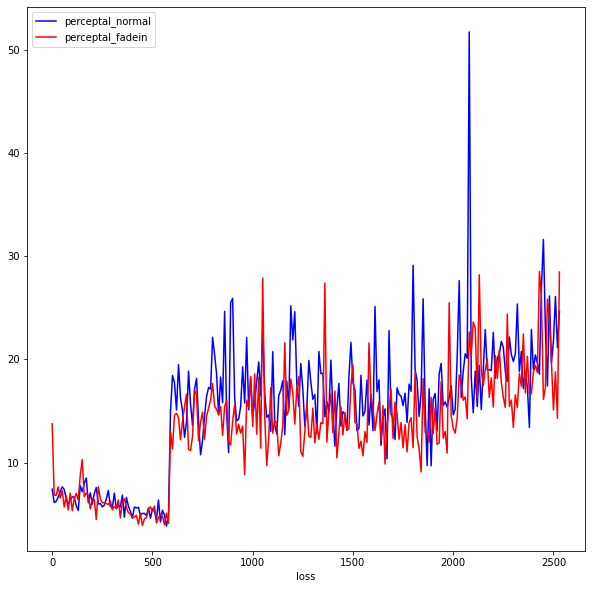

In [347]:
plt.figure(figsize=(10,10))
plt.plot(epochs, g_normal_loss[:,2], 'b-',epochs, g_fadein_loss[:,2], 'r-')
plt.legend(('perceptal_normal','perceptal_fadein'))
plt.xlabel('epoch')
plt.xlabel('loss')
#plt.savefig('perceptal')
plt.show()

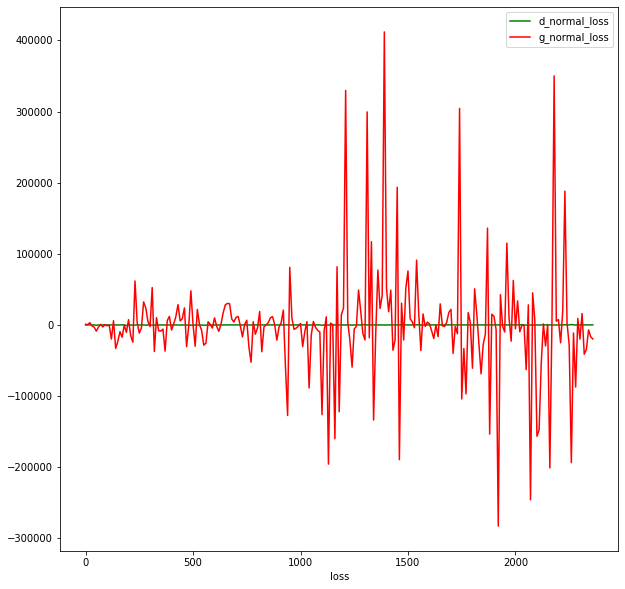

In [328]:
plt.figure(figsize=(10,10))
plt.plot(epochs,d_normal_loss[:,0], 'g-', epochs, g_normal_loss[:,0], 'r-')
plt.legend(('d_normal_loss', 'g_normal_loss'))
plt.xlabel('epoch')
plt.xlabel('loss')
#plt.savefig('normal_model_loss')
plt.show()

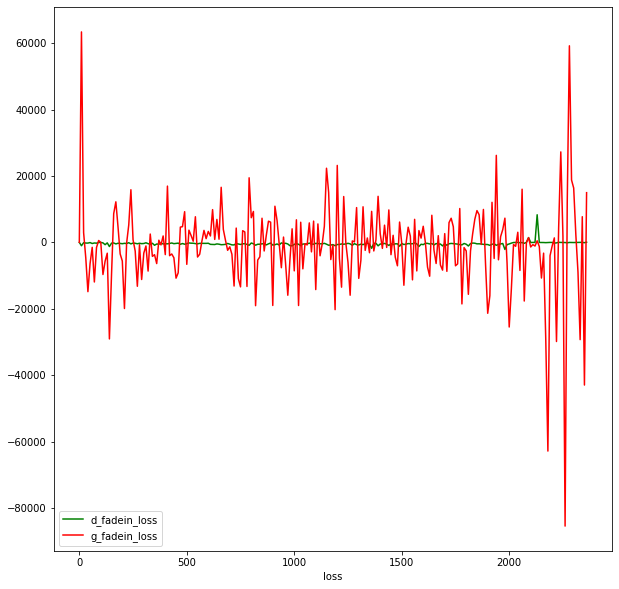

In [329]:
plt.figure(figsize=(10,10))
plt.plot(epochs,d_fadein_loss[:,0], 'g-', epochs, g_fadein_loss[:,0], 'r-')
plt.legend(('d_fadein_loss', 'g_fadein_loss'))
plt.xlabel('epoch')
plt.xlabel('loss')
#plt.savefig('fadein_model_loss')
plt.show()

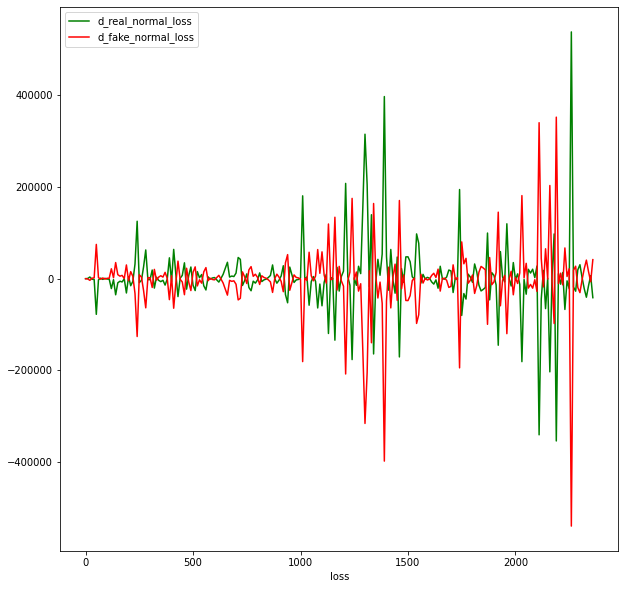

In [330]:
plt.figure(figsize=(10,10))
plt.plot(epochs,d_normal_loss[:,1], 'g-', epochs, d_normal_loss[:,2],'-r')
plt.legend(('d_real_normal_loss', 'd_fake_normal_loss'))
plt.xlabel('epoch')
plt.xlabel('loss')
#plt.savefig('d_normal_loss')
plt.show()

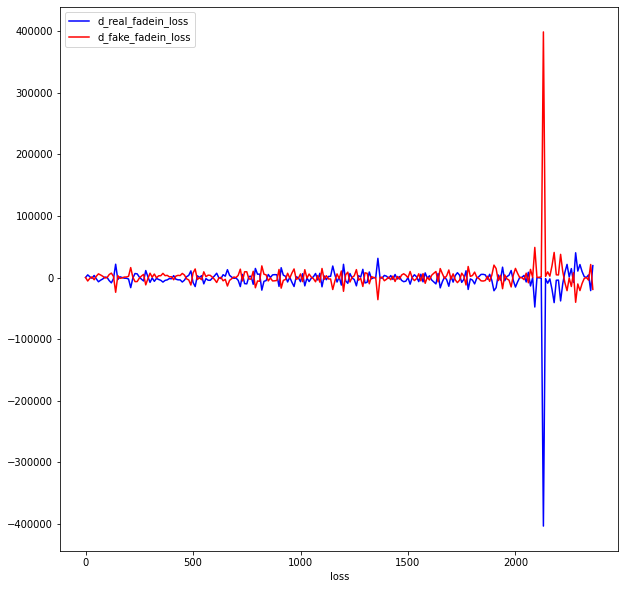

In [331]:
plt.figure(figsize=(10,10))
plt.plot(epochs,d_fadein_loss[:,1], 'b-', epochs, d_fadein_loss[:,2],'r-')
plt.legend(('d_real_fadein_loss','d_fake_fadein_loss'))
plt.xlabel('epoch')
plt.xlabel('loss')
#plt.savefig('d_normal_loss')
plt.show()

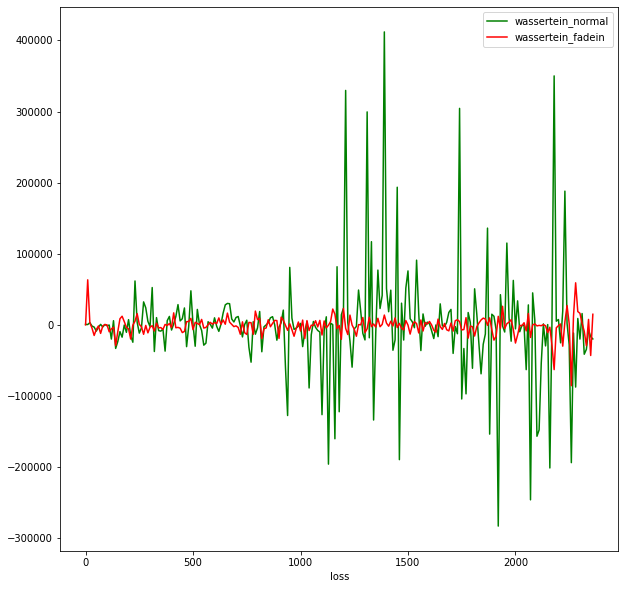

In [332]:
plt.figure(figsize=(10,10))
plt.plot(epochs, g_normal_loss[:,1], 'g-',epochs, g_fadein_loss[:,1], 'r-')
plt.legend(('wassertein_normal','wassertein_fadein'))
plt.xlabel('epoch')
plt.xlabel('loss')
#plt.savefig('perceptal')
plt.show()